<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/react_trans_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pytorch model for the reaction eqn 6*41*81 contaminant flow prediction

In [ ]:
import pickle as pk
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import json
import argparse
%matplotlib inline
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchsummary import summary
from google.colab import files
from time import time
from time import sleep
from IPython.display import clear_output
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        axs.set_xlim(0,Lx)
        axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
        name = title + '.pdf'
        plt.title(title)
    #         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
        plt.show()
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(10, 6))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            fig.colorbar(c01map, ax=ax, shrink=0.4)
        plt.suptitle(title)
        name = title + '.pdf'
        plt.tight_layout()
    #         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
        plt.show()
    return

# Dense ED 3D with autoregressive dataset

## load the training data

In [ ]:
with h5py.File('/content/drive/MyDrive/react_inverse/training_data/AR_dataset_500.hdf5', 'r') as file:
    AR_input = np.asarray(file['input'])
    AR_output = np.asarray(file['output'])
print('input shape: ',AR_input.shape, '\noutput shape: ', AR_output.shape)

input shape:  (4980, 3, 6, 41, 81) 
output shape:  (4980, 2, 6, 41, 81)


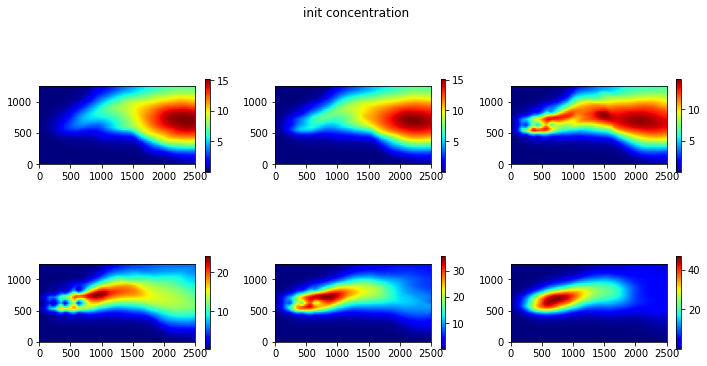

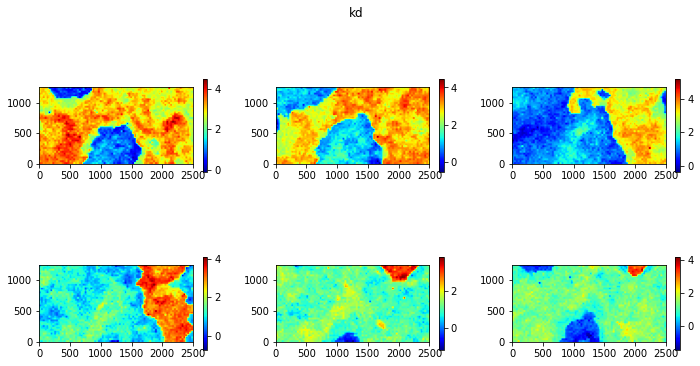

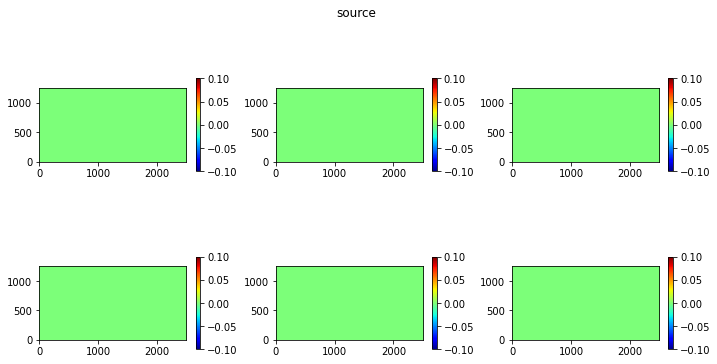

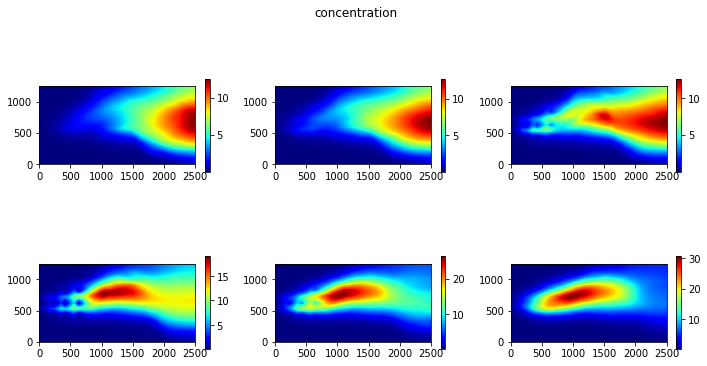

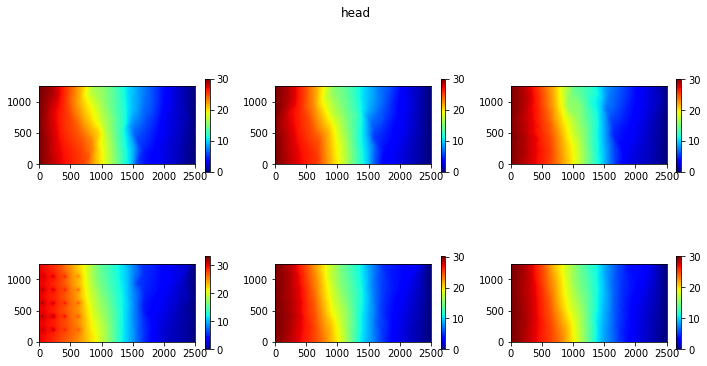

In [ ]:
np.random.seed(88)
ind = np.random.randint(0, len(AR_input), 1)
# ind = [0]
for i in ind:
    input = AR_input[i].copy()
    output = AR_output[i].copy()
    simple_plot(input[0], 'init concentration')
    simple_plot(input[1], 'kd')
    simple_plot(input[2], 'source')
    simple_plot(output[0], 'concentration')
    simple_plot(output[1], 'head')

## Dense ED 3d block

In [ ]:
"""
Convolutional Dense Encoder-Decoder Networks

Reference:
    https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

Yinhao Zhu
Dec 21, 2017
Dec 30, 2017
Jan 03, 2018

Shaoxing Mo
May 07, 2019

Zitong Zhou
Feb 18, 2021
"""


class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout3d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose3d(out_features, out_channels,
                                kernel_size=[3,ks,ks], stride=2, padding=[1,2,2],
                                output_padding=[1,0,0], bias=False)
            else:
                out_convt = nn.ConvTranspose3d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)

        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv3d(in_channels, num_init_features,
                            kernel_size=[3,7,7], stride=2, padding=[1,3,3], bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # use the softplus activation for concentration
        y[:,:self.out_channels-1] = F.softplus(y[:,:self.out_channels-1].clone(), beta=5)

        # in the example, pressure is the last output channel
        # use the sigmoid activation for pressure
        y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))


In [ ]:

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))


def cal_R2():
    "compute the test R2 score"
    n_test = args.n_test
    y_sum = np.full( (ntimes + 1, 2, 6, 41,81), 0.0)

    for i in range(n_test):
        y = np.full( (ntimes + 1, 2, 6, 41,81), 0.0)
        y[:ntimes] = y_test[i * ntimes: (i+1) * ntimes,[0]] # concentration at n_t time instances
        y[ntimes] = y_test[ i * ntimes,[1] ] # head
        y_sum = y_sum + y
    y_mean = y_sum / n_test

    nominator = 0.0
    denominator = 0.0
    for i in range(n_test):
        x = x_test[ i * ntimes: (i+1) * ntimes]
        y = np.full( (ntimes + 1,1,41,81), 0.0)
        y[:ntimes] = y_test[i * ntimes: (i+1) * ntimes,[0]] # concentration at n_t time instances
        y[ntimes] = y_test[ i * ntimes,[1] ] # head

        y_output = np.full( (ntimes + 1, 2, 6,41,81), 0.0)
        x_ii = np.full((1,x_test.shape[1], 6, 41,81), 0.0)
        y_ii_1 = np.full((6, 41, 81), 0.0)     # y_0 = 0
        for ii in range(ntimes):
            x_ii[0,0,:,:,:] = x[ii,0,:,:,:]   # hydraulic conductivity
            x_ii[0,1,:,:,:] = x[ii,1,:,:,:]   # source rate
            x_ii[0,2,:,:,:] = y_ii_1        # the ii_th predicted output
            x_ii_tensor = (torch.FloatTensor(x_ii)).to(device)
            model.eval()
            with th.no_grad():
                y_hat = model(x_ii_tensor)
            y_hat = y_hat.data.cpu().numpy()
            y_output[ii,0] = y_hat[0,0]
            if ii == ntimes - 1:
                y_output[ii+1,0] = y_hat[0,1]
            y_ii_1 = y_hat[0,0,:,:,:]
        nominator = nominator + ((y - y_output)**2).sum()
        denominator = denominator + ((y - y_mean)**2).sum()

    R2 = 1 - nominator/denominator
    print("R2: {}".format(R2))
    return R2

# find the maximum absolute prediction error at Nt concentration fields in each test sample,
# i.e., the results shown in Figure 13 of the paper
def max_err():
    n_test = args.n_test
    ErrMax = np.zeros((n_test*Nt))
    for i in range(n_test):
        x = x_test[ i * ntimes: (i+1) * ntimes - 2]
        y = np.full( (Nt,1,41,81), 0.0)
        y[:Nt] = y_test[i * ntimes: (i+1) * ntimes - 2,[0]] # concentration at n_t time instances

        y_output = np.full( (Nt, 1,41,81), 0.0)
        x_ii = np.full((1,x_test.shape[1],41,81), 0.0)
        y_ii_1 = np.full((41,81), 0.0)     # y_0 = 0
        for ii in range(Nt):
            x_ii[0,0,:,:] = x[ii,0,:,:]   # hydraulic conductivity
            x_ii[0,1,:,:] = x[ii,1,:,:]   # source rate
            x_ii[0,2,:,:] = y_ii_1        # the ii_th predicted output
            x_ii_tensor = (th.FloatTensor(x_ii)).to(device)
            model.eval()
            with th.no_grad():
                y_hat = model(x_ii_tensor)
            y_hat = y_hat.data.cpu().numpy()
            y_output[ii,0] = y_hat[0,0]
            y_ii_1 = y_hat[0,0,:,:]
        err = np.abs(y - y_output)

        ErrMax[i*Nt : (i+1)*Nt] = ( ( err.max(axis=1) ).max(axis=1) ).max(axis=1)

    np.savetxt(exp_dir +'/TestErrMax_ntrain{}.dat'.format(args.n_train), ErrMax, fmt='%10.4f')   # use exponential notation
    return None

In [ ]:
def save_stats(save_dir, logger, x_axis):

    rmse_train = logger['rmse_train']
    rmse_test = logger['rmse_test']
    r2_train = logger['r2_train']
    r2_test = logger['r2_test']

    if 'mnlp_test' in logger.keys():
        mnlp_test = logger['mnlp_test']
        if len(mnlp_test) > 0:
            plt.figure()
            plt.plot(x_axis, mnlp_test, label="Test: {:.3f}".format(np.mean(mnlp_test[-5:])))
            plt.xlabel('Epoch')
            plt.ylabel('MNLP')
            plt.legend(loc='upper right')
            plt.savefig(save_dir + "/mnlp_test.pdf", dpi=600)
            plt.close()
            np.savetxt(save_dir + "/mnlp_test.txt", mnlp_test)
    
    if 'log_beta' in logger.keys():
        log_beta = logger['log_beta']
        if len(log_beta) > 0:
            plt.figure()
            plt.plot(x_axis, log_beta, label="Test: {:.3f}".format(np.mean(log_beta[-5:])))
            plt.xlabel('Epoch')
            plt.ylabel('Log-Beta (noise precision)')
            plt.legend(loc='upper right')
            plt.savefig(save_dir + "/log_beta.pdf", dpi=600)
            plt.close()
            np.savetxt(save_dir + "/log_beta.txt", log_beta)

    plt.figure()
    plt.plot(x_axis, r2_train, label="Train: {:.3f}".format(np.mean(r2_train[-5:])))
    plt.plot(x_axis, r2_test, label="Test: {:.3f}".format(np.mean(r2_test[-5:])))
    plt.xlabel('Epoch')
    plt.ylabel(r'$R^2$-score')
    plt.legend(loc='lower right')
    plt.savefig(save_dir + "/r2.pdf", dpi=600)
    plt.close()
    np.savetxt(save_dir + "/r2_train.txt", r2_train)
    np.savetxt(save_dir + "/r2_test.txt", r2_test)

    plt.figure()
    plt.plot(x_axis, rmse_train, label="train: {:.3f}".format(np.mean(rmse_train[-5:])))
    plt.plot(x_axis, rmse_test, label="test: {:.3f}".format(np.mean(rmse_test[-5:])))
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.savefig(save_dir + "/rmse.pdf", dpi=600)
    plt.close()
    np.savetxt(save_dir + "/rmse_train.txt", rmse_train)
    np.savetxt(save_dir + "/rmse_test.txt", rmse_test)
    
def plot_prediction_bayes(save_dir, target, output, epoch, index):
    """Plot predictions at *one* test input

    Args:
        save_dir: directory to save predictions
        target (np.ndarray or torch.Tensor): （2， 6， 41， 81）
        output (np.ndarray or torch.Tensor): （2， 6， 41， 81)
        epoch (int): which epoch
        index (int): i-th prediction
    """
    target, output = to_numpy(target), to_numpy(output)
    target = np.reshape(target, (12, 41, 81))
    output = np.reshape(output, (12, 41, 81))
    pred_error = target - output
    # target: C x D x H x W
    sfmt = ticker.ScalarFormatter(useMathText=True)
    sfmt.set_powerlimits((-2, 2))
    cmap = 'jet'
    fig = plt.figure(1, (11, 5.6))
    axes_pad = 0.1
    cbar_pad = 0.1
    label_size = 6
    plt.rcParams["mpl_toolkits.legacy_colorbar"] = False
    subplots_position = [(4,6,i) for i in range(1, 25)]
    for i, subplot_i in enumerate(subplots_position):
        if i in [_ for _ in range(6)]+[_ for _ in range(12, 18)]:
            # share one colorbar
            grid = ImageGrid(fig, subplot_i,          # as in plt.subplot(111)
                              nrows_ncols=(2, 1),
                              axes_pad=axes_pad,
                              share_all=False,
                              cbar_location="right",
                              cbar_mode="single",
                              cbar_size="3%",
                              cbar_pad=cbar_pad,
                              )
            if i <6:
                data = (target[i], output[i])
            else:
                data = (target[i-6], output[i-6])
            channel = np.concatenate(data)
            vmin, vmax = np.amin(channel), np.amax(channel)
            # Add data to image grid
            for j, ax in enumerate(grid):
                im = ax.imshow(data[j], vmin=vmin, vmax=vmax, cmap=cmap)
                ax.set_axis_off()
            # ticks=np.linspace(vmin, vmax, 10)
            #set_ticks, set_ticklabels
            cbar = grid.cbar_axes[0].colorbar(im, format=sfmt)
            # cbar.ax.set_yticks((vmin, vmax))
            cbar.ax.yaxis.set_offset_position('left')
            cbar.ax.tick_params(labelsize=label_size)
            cbar.ax.toggle_label(True)

        else:
            grid = ImageGrid(fig, subplot_i,  # as in plt.subplot(111)
                              nrows_ncols=(1, 1),
                              axes_pad=axes_pad,
                            #  share_all=True,
                            #  aspect=True,
                              cbar_location="right",
                              cbar_mode="single",
                              cbar_size="6%",
                              cbar_pad=cbar_pad,
                              )
            if i < 12:
                data = [pred_error[i-6]]
            else:
                data = [pred_error[i-12]]

            for j, ax in enumerate(grid):
                im = ax.imshow(data[j], cmap=cmap)
                ax.set_axis_off()
                ax.set_axes_locator
                cbar = grid.cbar_axes[j].colorbar(im, format=sfmt)
                grid.cbar_axes[j].tick_params(labelsize=label_size)
                grid.cbar_axes[j].toggle_label(True)

    plt.tight_layout()##pad=0.25, w_pad=0.25, h_pad=0.25)
    # fig.subplots_adjust(wspace=0.075, hspace=0.075)
    # plt.show()
    plt.savefig(save_dir + '/pred_at_x_epoch{}_{}.pdf'.format(epoch, index), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def test(epoch, plot_intv):
    model.eval()
    loss = 0.
    for batch_idx, (input, target) in enumerate(test_loader):
        input, target = input.to(device), target.to(device)

        with torch.no_grad():
            output = model(input)
        loss += F.mse_loss(output, target,size_average=False).item()

        # plot predictions
        if epoch % plot_intv == 0 and batch_idx == len(test_loader) - 1:
            n_samples = 2
            idx = torch.LongTensor(np.random.choice(args.n_test, n_samples, replace=False))

            print("Index of data: {}".format(idx))
            print("X shape: {}".format(x_test.shape))

            for i in range(n_samples):
                model.eval()
                _input = torch.tensor(np.expand_dims(x_test[idx[i]], axis=0)).to(device)
                test_output = model(_input)
                test_target = y_test[idx[i]]
                plot_prediction_bayes(output_dir, test_target, test_output, epoch, idx[i])
                print("epoch {}, done with printing sample output {}".format(epoch, idx[i]))

    rmse_test = np.sqrt(loss / n_out_pixels_test)
    r2_score = 1 - loss / test_stats['y_var']
    print("epoch: {}, test r2-score:  {:.4f}".format(epoch, r2_score))
    return r2_score, rmse_test

In [ ]:
AR_output[100].shape

(2, 6, 41, 81)

## Set training arguments, loss function, testing, etc

In [ ]:
parser = argparse.ArgumentParser(description='Dnense Encoder-Decoder Convolutional Network')
parser.add_argument('-f')
parser.add_argument('--exp-name', type=str, default='AR-Net-WL', help='experiment name')
parser.add_argument('--blocks', type=list, default=(5, 10, 5), help='list of number of layers in each block in decoding net')
parser.add_argument('--growth-rate', type=int, default=40, help='output of each conv')
parser.add_argument('--drop-rate', type=float, default=0, help='dropout rate')
parser.add_argument('--bn-size', type=int, default=8, help='bottleneck size: bn_size * growth_rate')
parser.add_argument('--bottleneck', action='store_true', default=False, help='enable bottleneck in the dense blocks')
parser.add_argument('--init-features', type=int, default=48, help='# initial features after the first conv layer')

parser.add_argument('--data-dir', type=str, default="/content/drive/MyDrive/react_inverse/dense_ed_3d/", help='data directory')
parser.add_argument('--n-train', type=int, default=1000, help="number of training data")
parser.add_argument('--n-test', type=int, default=500, help="number of test data")

parser.add_argument('--w-c', type=float, default=5.0, help='weight value in the weighted loss')
parser.add_argument('--n-epochs', type=int, default=300, help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.005, help='learnign rate')
parser.add_argument('--weight-decay', type=float, default=5e-5, help="weight decay")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size for training (default: 100)')
parser.add_argument('--test-batch-size', type=int, default=32, help='input batch size for testing (default: 100)')
parser.add_argument('--log-interval', type=int, default=50, help='how many epochs to wait before logging training status')
parser.add_argument('--plot-interval', type=int, default=50, help='how many epochs to wait before plotting training status')

args = parser.parse_args()

In [ ]:
all_over_again = 'Feb_26'

exp_dir = args.data_dir + all_over_again + "/{}/Ntrs{}__Bks{}_Bts{}_Eps{}_wd{}_lr{}_K{}_w_c{}".\
    format(args.exp_name, args.n_train,args.blocks,
           args.batch_size, args.n_epochs, args.weight_decay, args.lr, args.growth_rate,args.w_c)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


ntimes = 10  # ntimes is the total number of time instances considered
Nt = 5      # Nt is the number of time instances with non-zero source rate

In [ ]:
x_train = AR_input[:args.n_train]
x_test = AR_input[args.n_train: args.n_train+args.n_test]
y_train = AR_output[:args.n_train]
y_test = AR_output[args.n_train: args.n_train+args.n_test]
y_train_mean = np.mean(y_train, 0)
y_train_var = np.sum((y_train - y_train_mean) ** 2)
print('y_train_var: {}'.format(y_train_var))
train_stats = {}
train_stats['y_mean'] = y_train_mean
train_stats['y_var'] = y_train_var

y_test_mean = np.mean(y_test, 0)
y_test_var = np.sum((y_test - y_test_mean) ** 2)
print('y_test_var: {}'.format(y_test_var))
test_stats = {}
test_stats['y_mean'] = y_test_mean
test_stats['y_var'] = y_test_var

data_train = utils.TensorDataset(torch.FloatTensor(x_train),
                                 torch.FloatTensor(y_train))
data_test = utils.TensorDataset(torch.FloatTensor(x_test),
                                torch.FloatTensor(y_test))
kwargs = {'num_workers': 4,
          'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = DataLoader(data_train,
                          batch_size=args.batch_size,
                          shuffle=True, **kwargs)

test_loader = DataLoader(data_test,
                         batch_size=args.test_batch_size,
                         shuffle=True, **kwargs)

y_train_var: 10414080000.0
y_test_var: 6024158208.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseED(x_train.shape[1], y_train.shape[1], blocks=args.blocks, growth_rate=args.growth_rate,
                drop_rate=args.drop_rate, bn_size=args.bn_size,
                num_init_features=args.init_features, bottleneck=args.bottleneck).to(device)
# print(model)
print("number of parameters: {}\nnumber of layers: {}"
              .format(*model._num_parameters_convlayers()))

optimizer = optim.Adam(model.parameters(), lr=args.lr,
                       weight_decay=args.weight_decay)

scheduler = ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=10,
                    verbose=True, threshold=0.0001, threshold_mode='rel',
                    cooldown=0, min_lr=0, eps=1e-08)

n_out_pixels_train = len(train_loader.dataset) * train_loader.dataset[0][1].numel()
n_out_pixels_test = len(test_loader.dataset) * test_loader.dataset[0][1].numel()
# summary(model,x_train[0].shape)

number of parameters: 8434802
number of layers: 27


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 50, training r2-score: 0.380285
Index of data: tensor([175, 304])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


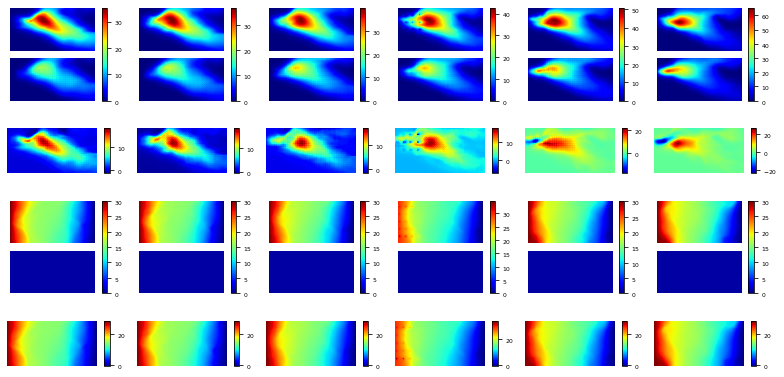

epoch 50, done with printing sample output 175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


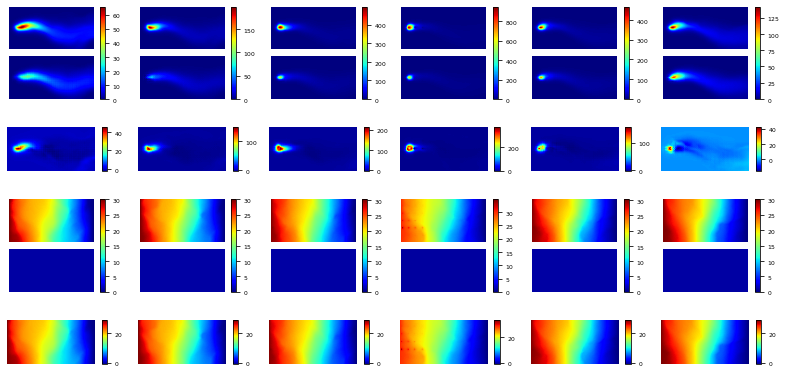

epoch 50, done with printing sample output 304
epoch: 50, test r2-score:  0.2870
loss: 2637114.5


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch    70: reducing learning rate of group 0 to 5.0000e-04.
Epoch    98: reducing learning rate of group 0 to 5.0000e-05.
epoch: 100, training r2-score: 0.408494
Index of data: tensor([497, 220])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


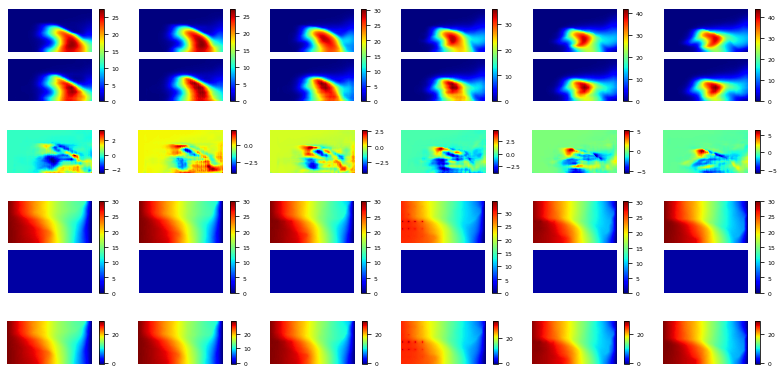

epoch 100, done with printing sample output 497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


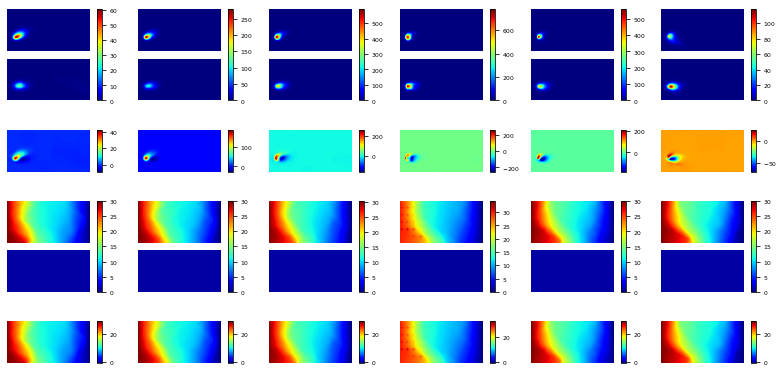

epoch 100, done with printing sample output 220
epoch: 100, test r2-score:  0.4532
loss: 2614178.5


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch   118: reducing learning rate of group 0 to 5.0000e-06.
Epoch   139: reducing learning rate of group 0 to 5.0000e-07.
epoch: 150, training r2-score: 0.411421
Index of data: tensor([142, 290])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


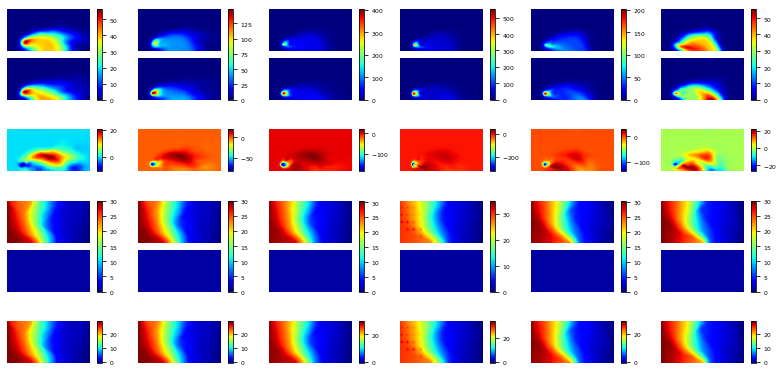

epoch 150, done with printing sample output 142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


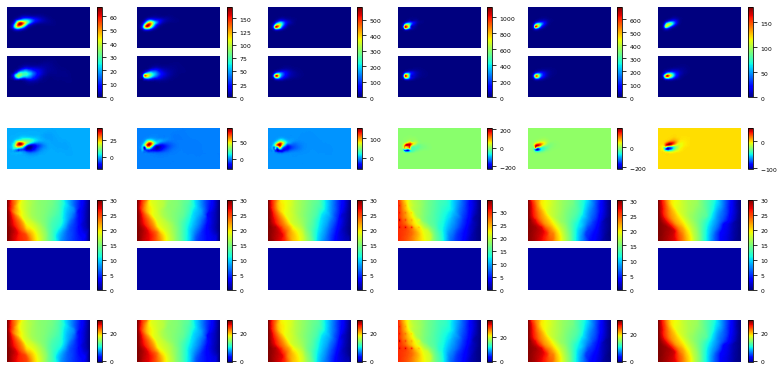

epoch 150, done with printing sample output 290
epoch: 150, test r2-score:  0.4547
loss: 2161771.5


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch   154: reducing learning rate of group 0 to 5.0000e-08.
Epoch   165: reducing learning rate of group 0 to 5.0000e-09.
epoch: 200, training r2-score: 0.410372
Index of data: tensor([488, 364])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


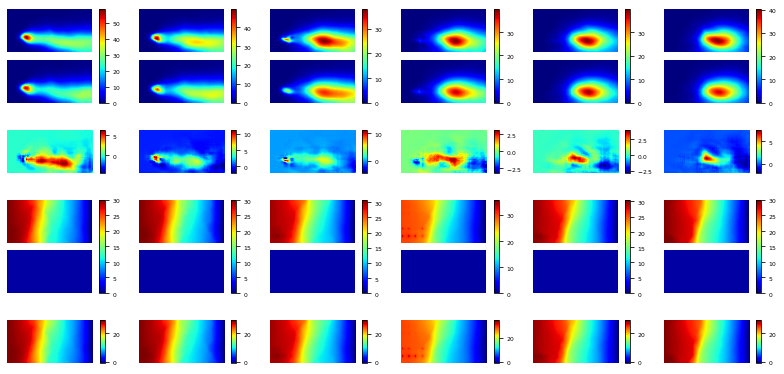

epoch 200, done with printing sample output 488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


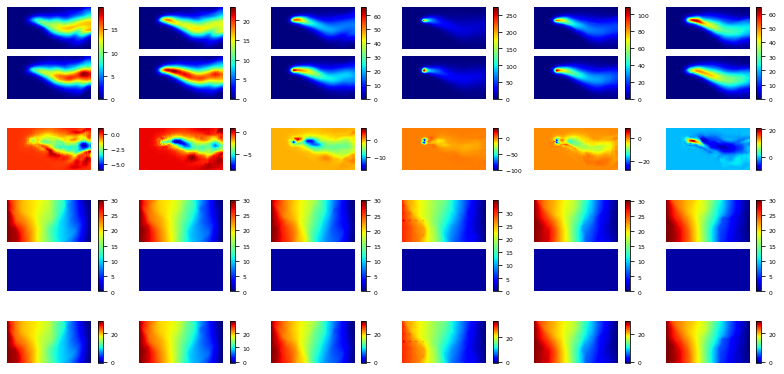

epoch 200, done with printing sample output 364
epoch: 200, test r2-score:  0.4552
loss: 2425021.5


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 250, training r2-score: 0.414150
Index of data: tensor([69, 99])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


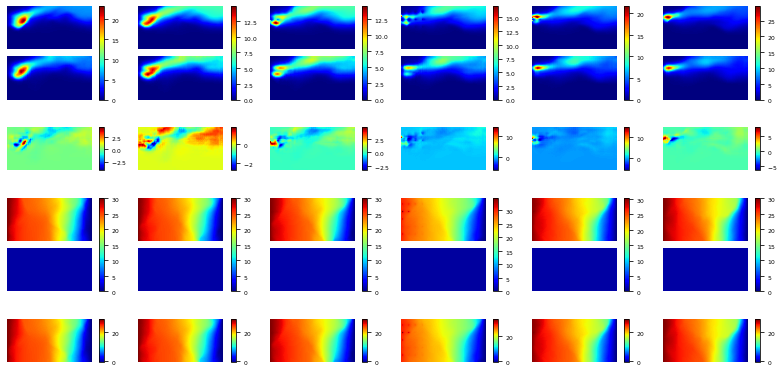

epoch 250, done with printing sample output 69


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


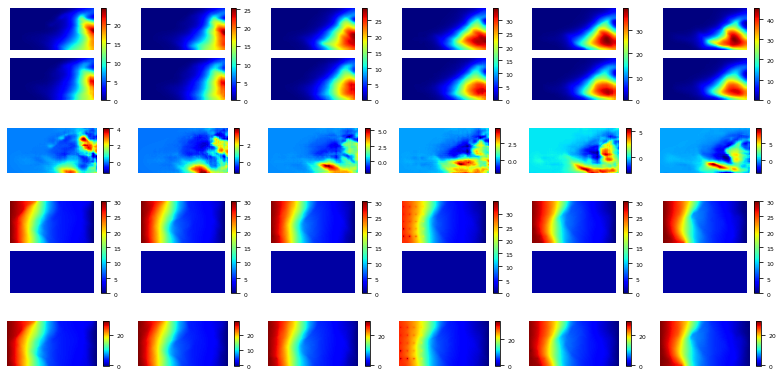

epoch 250, done with printing sample output 99
epoch: 250, test r2-score:  0.4549
loss: 2157875.75


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 300, training r2-score: 0.407847
Index of data: tensor([344, 480])
X shape: (500, 3, 6, 41, 81)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


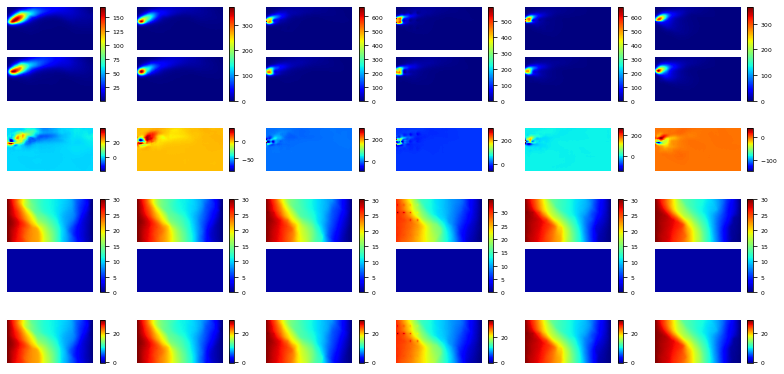

epoch 300, done with printing sample output 344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


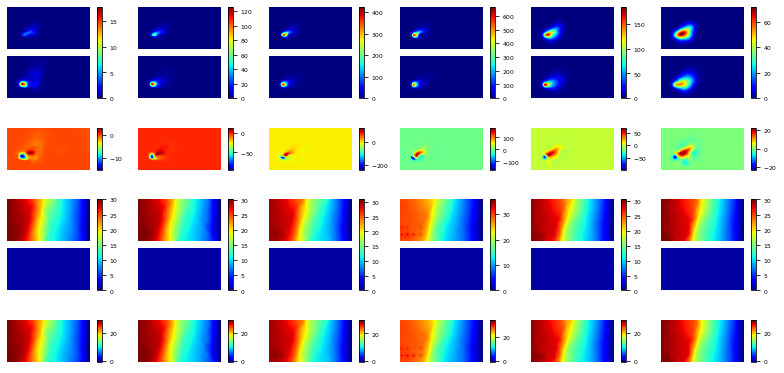

epoch 300, done with printing sample output 480
epoch: 300, test r2-score:  0.4531
loss: 2197939.0
Done training 300 epochs with 1000 data using 5962.238199710846 seconds


In [ ]:
logger = {}
logger['rmse_train'] = []
logger['rmse_test'] = []
logger['r2_train'] = []
logger['r2_test'] = []

tic = time()
R2_test_self = []
r2_train, r2_test = [], []
rmse_train, rmse_test = [], []
for epoch in range(1, args.n_epochs + 1):
    # train
    model.train()
    mse = 0.
    for batch_idx, (input, target) in enumerate(train_loader):
        input, target= input.to(device), target.to(device)
        model.zero_grad()
        output = model(input)

        loss = F.l1_loss(output, target,size_average=False)

        # for computing the RMSE criterion solely
        loss_mse = F.mse_loss(output, target,size_average=False)

        loss.backward()
        optimizer.step()
        mse += loss_mse.item()

    rmse = np.sqrt(mse / n_out_pixels_train)
    if epoch % args.log_interval == 0:
        r2_score = 1 - mse / train_stats['y_var']
        print("epoch: {}, training r2-score: {:.6f}".format(epoch, r2_score))
        r2_train.append(r2_score)
        rmse_train.append(rmse)
        r2_t, rmse_t = test(epoch, plot_intv=args.plot_interval)
        r2_test.append(r2_t)
        rmse_test.append(rmse_t)
        print("loss: {}".format(loss))

    scheduler.step(rmse)

    # save model
    if epoch == args.n_epochs:
        torch.save(model.state_dict(), model_dir + "/model_epoch{}.pth".format(epoch))
tic2 = time()
print("Done training {} epochs with {} data using {} seconds"
      .format(args.n_epochs, args.n_train, tic2 - tic))

x = np.arange(args.log_interval, args.n_epochs + args.log_interval,
                args.log_interval)
plt.figure()
plt.plot(x, r2_train, 'k', label="train: {:.3f}".format(np.mean(r2_train[-5: -1])))
plt.plot(x, r2_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(r2_test[-5: -1])))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('$R^2$', fontsize=14)
plt.legend(loc='lower right')
plt.savefig(exp_dir + "/r2.png", dpi=400)
plt.close()
np.savetxt(exp_dir + "/r2_train.txt", r2_train)
np.savetxt(exp_dir + "/r2_test.txt", r2_test)

plt.figure()
plt.plot(x, rmse_train, 'k', label="train: {:.3f}".format(np.mean(rmse_train[-5: -1])))
plt.plot(x, rmse_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(rmse_test[-5: -1])))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(loc='upper right')
plt.savefig(exp_dir + "/rmse.png", dpi=400)
plt.close()
np.savetxt(exp_dir + "/rmse_train.txt", rmse_train)
np.savetxt(exp_dir + "/rmse_test.txt", rmse_test)

# save args and time taken
args_dict = {}
for arg in vars(args):
    args_dict[arg] = getattr(args, arg)
args_dict['time'] = tic2 - tic
n_params, n_layers = model._num_parameters_convlayers()
args_dict['num_layers'] = n_layers
args_dict['num_params'] = n_params
with open(exp_dir + "/args.txt", 'w') as file:
    file.write(json.dumps(args_dict))

# R2_test_s = cal_R2()
# R2_test_self.append(R2_test_s)
# np.savetxt(exp_dir + "/R2_test_self.txt", R2_test_self)

## sensor locations, check if the N_obs are correct:

In [ ]:
np.random.seed(888)
y_obs = np.linspace(5, 35, num=4)
x_obs = np.linspace(30, 80, num=5)
sensor = np.zeros((6, 41, 81))
for i in range(len(y_obs)):
    for j in range(6):
        for k in range(len(x_obs)):
            sensor[j, int(y_obs[i]), int(x_obs[k])] = 1
simple_plot(sensor, 'sensor location')
sensor = sensor>0
with open('/content/drive/MyDrive/react_inverse/dense_ed_3d/sensor_loc.pkl', 'wb') as file:
    pk.dump(sensor, file)